In [1]:
import torch
from torch import nn
from torch import functional as F
import matplotlib.pyplot as plt
import numpy as np
from livelossplot import PlotLosses
from Tools.NNtools import *
import seaborn as sns, numpy as np
import functools
from scipy.spatial.distance import squareform
import math

### IMPORTS

In [2]:
from Inference.Variational import MeanFieldVariationalDistribution

In [3]:
class VariationalGenerativeNetwork(nn.Module):
    def __init__(self, nntransform, lat_dim, mu=0.0, sigma=1.0, device='cpu'):
        super(VariationalGenerativeNetwork, self).__init__()
        self.device = device
        self.lat_dim = lat_dim
        
        self.mfvar = MeanFieldVariationalDistribution(lat_dim,mu,sigma, device)
        self.nntransform = nntransform
        
          
    def sample(self, n=1):
        return self.nntransform(self.mfvar.sample(n))

In [4]:
def show_variational_posterior_predictive(q):
    x_test = torch.linspace(-2.0, 2.0).unsqueeze(1).to(device)
    # Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)
    plt.xlim(-2, 2) 
    plt.ylim(-4, 4) 
    plt.scatter(x_data.cpu(), y_data.cpu())
    for _ in range(1000):
        z = q.sample()
        set_all_parameters(model, z)
        y_test = model(x_test)

        plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')

In [5]:
# Find what device to work with
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device 

device(type='cuda', index=1)

In [6]:
torch.set_default_dtype(torch.float64)

# Model principal

In [7]:
def flip_parameters_to_tensors(module):
    attr = []
    while bool(module._parameters):
        attr.append( module._parameters.popitem() )
    setattr(module, 'registered_parameters_name', [])

    for i in attr:
        setattr(module, i[0], torch.zeros(i[1].shape,requires_grad=True))
        module.registered_parameters_name.append(i[0])

    module_name = [k for k,v in module._modules.items()]

    for name in module_name:
        flip_parameters_to_tensors(module._modules[name])

In [8]:
def set_all_parameters(module, theta):
    count = 0  

    for name in module.registered_parameters_name:
        a = count
        b = a + getattr(module, name).numel()
        t = torch.reshape(theta[0,a:b], getattr(module, name).shape)
        setattr(module, name, t)

        count += getattr(module, name).numel()

    module_name = [k for k,v in module._modules.items()]
    for name in module_name:
        count += set_all_parameters(module._modules[name], theta)
    return count

In [9]:
def _log_norm(x, mu, std):
        return -0.5 * torch.log(2*np.pi*std**2) -(0.5 * (1/(std**2))* (x-mu)**2)

In [10]:
def show_variational_posterior_predictive(q):
    x_test = torch.linspace(-2.0, 2.0).unsqueeze(1).to(device)
    # Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)
    plt.xlim(-2, 2) 
    plt.ylim(-4, 4) 
    plt.scatter(x_data.cpu(), y_data.cpu())
    for _ in range(1000):
        z = q.sample() + ctheta
        set_all_parameters(model, z)
        y_test = model(x_test)

        plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')

In [31]:
# load data and make it in proper shape
data = torch.load('Data/foong_data.pt')
x_data = data[0].to(device).double()
y_data = data[1].to(device).double()
y_data = y_data.unsqueeze(-1)

In [32]:
model = nn.Sequential( nn.Linear(1, 50),
                       nn.Tanh(), 
                       nn.Linear(50, 1),
                     ).to(device)

In [33]:
param_count = get_param(model).shape[0]
param_count

151

In [34]:
flip_parameters_to_tensors(model)

In [35]:
prior = MeanFieldVariationalDistribution(param_count, sigma=1.0, device=device)
prior.mu.requires_grad = False
prior.rho.requires_grad = False

In [36]:
def logprior(x):
    return prior.log_prob(x)

In [37]:
def loglikelihood(theta, model, x, y, sigma_noise):
    #set_param(model, theta)
    set_all_parameters(model, theta)
    y_pred = model(x)
    L = _log_norm(y_pred, y, torch.tensor([sigma_noise],device=device))
    return torch.sum(L).unsqueeze(-1)

In [38]:
def logposterior(theta, model, x, y, sigma_noise):
    return logprior(theta) + loglikelihood(theta, model, x, y, sigma_noise)

# Modèle génératif: Hypernet autoencodeur

In [ ]:
def LinSigmoid(x):
    return 1/(1+(math.e**-x)) + 0.05*x

In [ ]:
def LinTanh(x):
    return torch.tanh(x) + 0.05*x

In [ ]:
def LinELU(x):
    return torch.nn.functional.elu(x) + 0.01*x + 1.0

In [ ]:
def RBF(x):
    return torch.exp(-x**2)

In [ ]:
def RectifiedQuad(x):
    return nn.functional.relu(x)**2

In [ ]:
def swish(x, beta = 1):
    return (x * torch.sigmoid(beta * x))

In [ ]:
plt.plot(x_lin.detach().cpu().numpy(), LinELU(x_lin).detach().cpu().numpy())

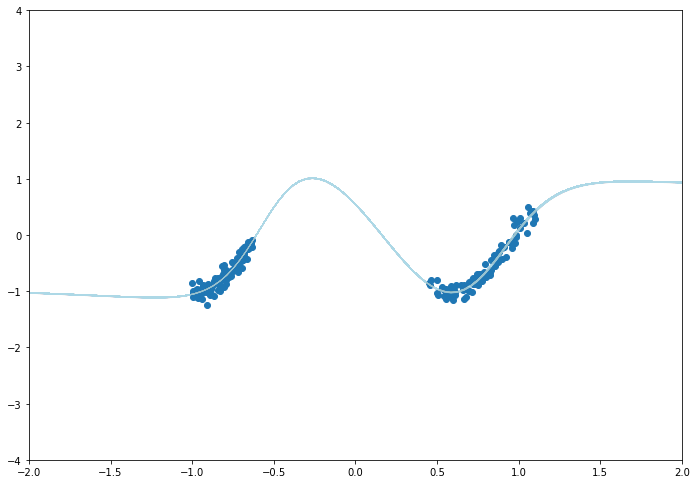

In [122]:
class Net(nn.Module):
    def __init__(self,lat_dim, H, theta_dim):
        super(Net, self).__init__()
        self.L1 = nn.Linear(lat_dim, H)
        self.L2 = nn.Linear(H, H)
        self.L3 = nn.Linear(H, H)
        self.L4 = nn.Linear(H, H)
        self.L5 = nn.Linear(H, H)
        self.L6 = nn.Linear(H, theta_dim)

    def forward(self, input):
        h = nn.functional.relu(self.L1(input))
        h = nn.functional.relu(self.L2(h))
        h = nn.functional.relu(self.L3(h))
        h = nn.functional.relu(self.L4(h))
        h = nn.functional.relu(self.L5(h))
        h = self.L6(h)
        return h
    
lat_dim = 1
H = 50
theta_dim = param_count
nntransform = Net(lat_dim,H,theta_dim)
nntransform.to(device)

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.1)
        torch.nn.init.normal_(m.bias, mean=0.0, std=0.0001)
        #torch.nn.init.xavier_uniform_(m.weight)
        #torch.nn.init.uniform_(m.bias)
        

nntransform.apply(init_weights)

q = VariationalGenerativeNetwork(nntransform, lat_dim, mu=0.0, sigma=1.0, device=device)
q.mfvar.mu.requires_grad_(False)
q.mfvar.rho.requires_grad_(False)

show_variational_posterior_predictive(q)

In [ ]:
class PolynomialNet(nn.Module):
    def __init__(self,lat_dim, H,theta_dim):
        super(PolynomialNet, self).__init__()
        self.L1 = nn.Linear(lat_dim, H)
        self.L2 = nn.Linear(2*H, H)
        self.L3 = nn.Linear(2*H, H)
        self.L4 = nn.Linear(2*H, H)
        self.L5 = nn.Linear(2*H, H)
        self.L6 = nn.Linear(2*H, theta_dim)

    def forward(self, input):
        h = torch.cat([nn.functional.relu(self.L1(input)), nn.functional.relu(self.L1(input))**2], dim=1) 
        h = torch.cat([nn.functional.relu(self.L2(h)), nn.functional.relu(self.L2(h))**2], dim=1) 
        h = torch.cat([nn.functional.relu(self.L3(h)), nn.functional.relu(self.L3(h))**2], dim=1)
        h = torch.cat([nn.functional.relu(self.L4(h)), nn.functional.relu(self.L4(h))**2], dim=1) 
        h = torch.cat([nn.functional.relu(self.L5(h)), nn.functional.relu(self.L5(h))**2], dim=1) 
        h = self.L6(h)
        return h
    
lat_dim = 10
H = 50
nntransform = PolynomialNet(lat_dim,H, param_count)
nntransform.to(device)

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.1)
        torch.nn.init.normal_(m.bias, mean=0.0, std=0.1)
        #torch.nn.init.xavier_uniform_(m.weight)
        #torch.nn.init.uniform_(m.bias)
        

nntransform.apply(init_weights)

q = VariationalGenerativeNetwork(nntransform, lat_dim, mu=0.0, sigma=1.0, device=device)
q.mfvar.mu.requires_grad_(False)
q.mfvar.rho.requires_grad_(False)

show_variational_posterior_predictive(q)

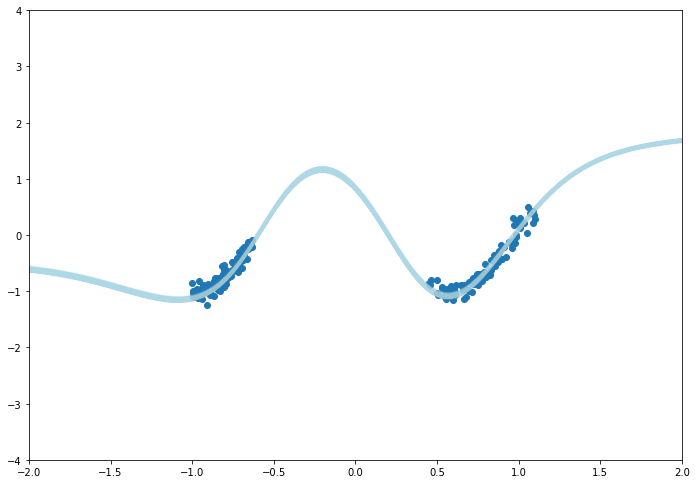

In [211]:
class DenseBlockEncoder(torch.nn.Module):
    def __init__(self, wSequence, activation):
        super().__init__()
        self.fullyConnectedList = nn.ModuleList()
        self.activation = activation
        for j in range(len(wSequence) - 1):
            self.fullyConnectedList.append(nn.Linear(sum(wSequence[:j + 1]), wSequence[j + 1]))

    def forward(self, *inputs):
        hidden, = inputs
        for j in range(len(self.fullyConnectedList) - 1):
            layer = self.fullyConnectedList[j]
            hidden = self.activation(torch.cat([layer(hidden), hidden], dim=1))
        layer = self.fullyConnectedList[-1]
        hidden = layer(hidden)
        return hidden

lat_dim = 10
H = 200
nntransform = DenseBlockEncoder([lat_dim,H,H,param_count], nn.functional.relu)
nntransform.to(device)

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.1)
        torch.nn.init.normal_(m.bias, mean=0.0, std=0.01)
        #torch.nn.init.xavier_uniform_(m.weight)
        #torch.nn.init.uniform_(m.bias)
        #m.bias.data.fill_(0.)
        

nntransform.apply(init_weights)

q = VariationalGenerativeNetwork(nntransform, lat_dim, mu=0.0, sigma=0.01, device=device)
q.mfvar.mu.requires_grad_(False)
q.mfvar.rho.requires_grad_(False)

show_variational_posterior_predictive(q)

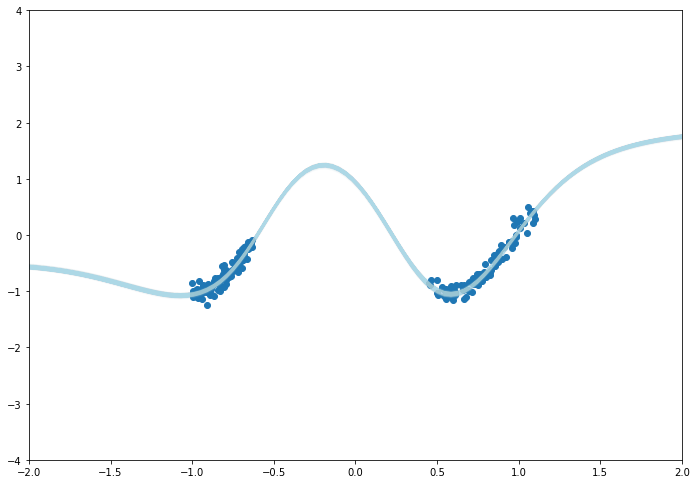

In [209]:
show_variational_posterior_predictive(q)

# Training #

In [212]:
N_ELBO = 1200

In [213]:
optimizer = torch.optim.Adam(q.parameters(), lr=0.001)

In [214]:
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=200, factor=0.1)

In [215]:
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9999)

In [216]:
%matplotlib inline
liveloss = PlotLosses()

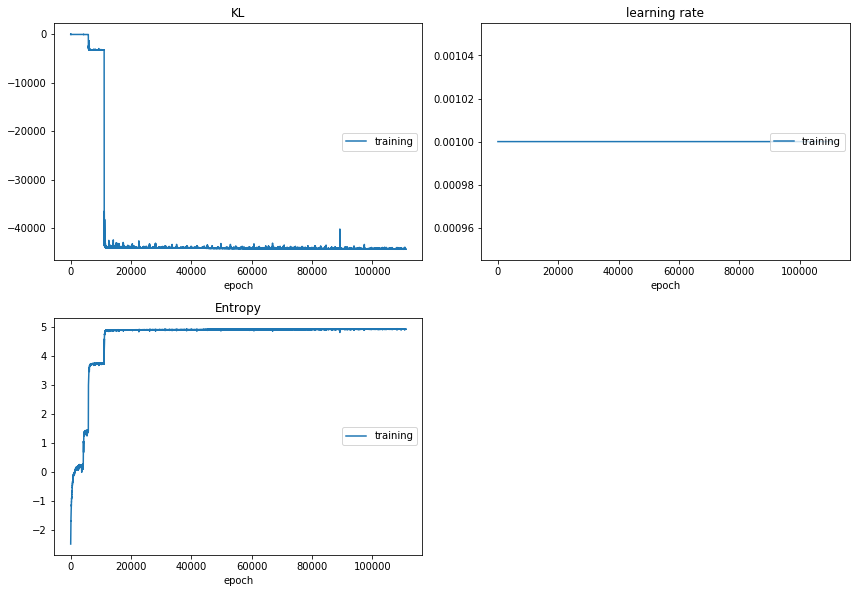

KL:
training   (min: -44335.073, max:   92.162, cur: -44307.837)

learning rate:
training   (min:    0.001, max:    0.001, cur:    0.001)

Entropy:
training   (min:   -2.549, max:    4.944, cur:    4.926)


In [220]:
for t in range(100000):
    logs = {}
    optimizer.zero_grad()

    X = q.sample(N_ELBO)
    X = X + ctheta
    ExpectedPosterior = logposterior(X, model, x_data, y_data, sigma_noise=0.1).mean()

    D = torch.nn.functional.pdist(X,p=2.0)

    Entropy = torch.log(D).mean()

    L = -ExpectedPosterior-10000*Entropy

    if not torch.isfinite(L):
        with torch.no_grad():
            for parameter in q.parameters():
                if parameter.requires_grad is True:
                    parameter.add_(torch.randn(parameter.size(), device=device) * 0.01)
    else:
        L.backward(retain_graph=True)
        #torch.nn.utils.clip_grad_value_(q.parameters(), 10000.0)
        optimizer.step()

    with torch.no_grad():
        learning_rate = optimizer.param_groups[0]['lr']

        #scheduler.step() #L.detach().clone().cpu().numpy())

        logs['KL'] = L.detach().clone().cpu().numpy()
        logs['learning rate'] = learning_rate
        logs['Entropy'] = Entropy.detach().clone().cpu().numpy()
        liveloss.update(logs)

        if t % 100 == 0:
            liveloss.draw()
        if t % 1000 == 0:
            show_variational_posterior_predictive(q)

    if learning_rate < 0.00001:
        break

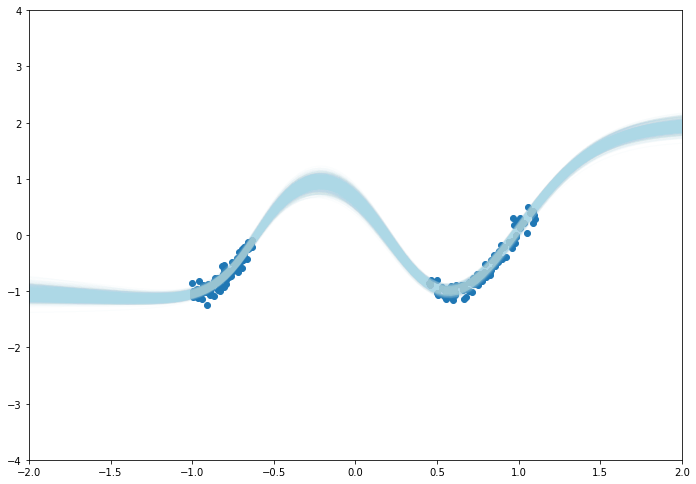

In [221]:
show_variational_posterior_predictive(q)

In [199]:
theta = torch.nn.Parameter( prior.sample(), requires_grad=True)
theta.to(device)

Parameter containing:
tensor([[ 0.1552,  1.2182,  0.9386,  1.6517,  0.9149,  0.2559, -1.3259,  0.0403,
         -0.4416, -0.4260, -2.2880,  2.9613,  0.6210,  0.4782,  0.8594, -1.3079,
         -2.0611, -1.5065, -1.5157, -0.8977, -1.7607, -0.5604, -1.2201, -0.6568,
         -0.2780, -1.6385,  1.1417, -0.2098,  0.6649, -1.4538,  0.0793,  0.4675,
         -1.4429,  1.2146,  0.6140, -0.8490,  0.3956,  0.6296,  1.5495,  1.0281,
          1.3360,  0.5756,  0.7914,  0.4053, -0.0882, -0.2838, -0.9702, -0.7028,
          1.5998,  1.1307, -0.7653,  2.0394, -2.3642,  0.1316,  1.0293,  0.0526,
          0.2385, -0.4996, -2.3730,  1.6676, -0.4288, -0.9602, -0.3598,  0.1224,
          1.2647, -0.7648, -1.4363,  0.9238,  0.5694, -0.6556, -0.5140,  0.5846,
          0.4896, -1.5560, -0.3701,  0.6484, -0.6962,  1.1235,  0.4190,  0.2504,
          0.6775,  0.7995, -0.1784,  0.2370, -0.6211, -0.1865,  0.2659,  0.4629,
          0.9185,  1.1867,  1.2892,  0.1083,  0.1535,  0.6482,  1.4094, -0.8570,
      

In [200]:
optimizer = torch.optim.Adam([theta], lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=500, factor=0.8)

In [201]:
%matplotlib inline
liveloss = PlotLosses()

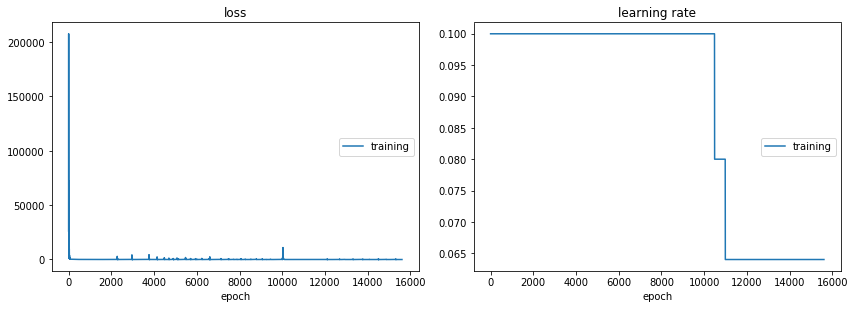

loss:
training   (min:  -22.307, max: 767704.260, cur:  -22.307)

learning rate:
training   (min:    0.064, max:    0.100, cur:    0.064)


KeyboardInterrupt: 

In [202]:
for t in range(100000):
    logs = {}
    optimizer.zero_grad()

    L = -torch.mean(logposterior(theta, model, x_data, y_data, sigma_noise=0.1))
    L.backward()
    
    #torch.nn.utils.clip_grad_norm_([theta], 0.1)

    learning_rate = optimizer.param_groups[0]['lr']

    scheduler.step(L.detach().clone().cpu().numpy())
    optimizer.step()
    
    logs['loss'] = L.detach().clone().cpu().numpy()
    logs['learning rate'] = learning_rate
    liveloss.update(logs)
    
    if t % 100 == 0:
        liveloss.draw()

    if learning_rate < 0.001:
        break

In [204]:
ctheta = theta.detach().clone()

In [205]:
ctheta

tensor([[ 6.6969e-01,  1.6118e+00,  1.8091e+00,  8.6332e-03,  1.5778e-02,
          2.3466e-02, -5.7449e-03, -1.7588e-02,  8.4239e-02, -5.0285e-01,
         -1.6486e+00,  1.2194e+00, -2.7886e-04,  2.4001e-02, -1.1282e-04,
         -4.0176e-02,  6.8582e-03, -9.0227e-03,  3.1650e-03, -3.9397e-05,
          1.2432e-03, -9.1268e-03,  1.3006e-03,  4.7236e-03, -9.8684e-04,
         -8.1088e-04,  7.5469e-05,  4.5272e-04,  1.0251e-03,  7.1328e-05,
         -7.1542e-04, -2.2330e-04, -4.7258e-04,  1.1388e-03, -3.2566e-03,
          6.5376e-05,  3.7142e-03, -2.9473e-04,  2.2368e-03,  5.9748e-03,
          2.7487e-02, -1.1813e-02,  1.5655e-02,  2.1545e-03, -2.3692e-02,
         -2.3665e-02, -1.3996e-01, -2.2234e-02,  1.8259e-01,  1.6730e+00,
         -2.4002e+00,  2.9039e+00, -8.6415e-02, -1.1417e-02, -1.6069e-02,
          1.7084e-03,  2.0368e-02, -3.0357e-02,  1.7662e-01,  2.0341e+00,
         -1.3867e+00, -5.9653e-04, -8.0869e-03,  8.8867e-04,  1.5532e-02,
         -4.0643e-03,  6.0618e-03, -2.

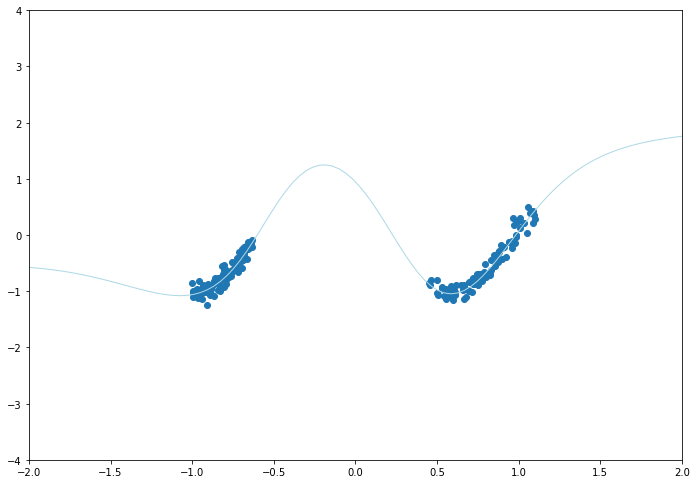

In [203]:
x_test = torch.linspace(-2.0, 2.0).unsqueeze(1).to(device)
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.xlim(-2, 2) 
plt.ylim(-4, 4) 
plt.scatter(x_data.cpu(), y_data.cpu())

set_all_parameters(model, theta)
y_test = model(x_test)
plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=1.0, linewidth=1, color='lightblue')    


In [ ]:

    # Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)
    plt.xlim(-2, 2) 
    plt.ylim(-4, 4) 
    plt.scatter(x_data.cpu(), y_data.cpu())
    for _ in range(1000):
        z = q.sample() + ctheta
        set_all_parameters(model, z)
        y_test = model(x_test)

        plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')